In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [2]:
# 讀入USDCNH 5分K資料，資料期間為2017/1/2到2019/10/24
df = pd.read_csv("USDCNHXXX_chart_5min.csv", encoding = "utf-8")

In [3]:
# 觀察離岸人民幣匯價後，決定利用5分K收盤價，以0.05為關卡單位，計算上檔跟下檔，例如：現收盤價為6.724，則上檔為6.75，下檔為6.7。
# 本當沖策略邏輯：在遇到整數關卡時(上檔、下檔)，常會有供需失衡的情況發生，例子如下
# 多頭部位的人，PT會設在上檔往下一點點形成上檔壓力，SL會設在下檔往下一點點因為大部分人不喜歡停損
# 空頭部位的人，PT會設在下檔往上一點點形成下檔支撐，SL會設在上檔往上一點點因為大部分人不喜歡停損
# 如此導致供需失衡的發生，本策略邏輯為接近下檔時做多單(有支撐)，接近上檔時做空單(有壓力)，而若真的突破上/下檔則會翻單(失衡導致價格會追漲追跌)。
df["floor"] = [(i // 0.05) * 0.05 for i in df["Close"]]
df["ceil"] = df["floor"] + 0.05

In [4]:
df_count = df[["Datetime"]].copy()
df_count["Date"] = [i.split(" ")[0] for i in df_count["Datetime"]]
df_count["Date"] = [i.split("/")[0] + "/" + i.split("/")[1].zfill(2) +"/" + i.split("/")[2].zfill(2) for i in df_count["Date"]]
df_count = df_count.groupby("Date").count().reset_index()
df_count

,Date,Datetime
0,2017/01/02,215
1,2017/01/03,288
2,2017/01/04,288
3,2017/01/05,288
4,2017/01/06,288
...,...,...
874,2019/10/19,288
875,2019/10/21,288
876,2019/10/22,288
877,2019/10/23,288


In [5]:
# 將2017/1/2的215根5分K 跟 2019/10/24的61根5分K刪掉，因為不足一天288根5分K。
df.drop(index = [i for i in range(215)], axis = 0, inplace = True)
df.drop(index = [i for i in range(252791,252852)], axis = 0, inplace = True)
df.reset_index(drop = True, inplace = True)

In [6]:
df["Weekday"] = [datetime.datetime.strptime(i.split(" ")[0], "%Y/%m/%d").weekday() for i in df["Datetime"]]

Text(0.5, 1.0, 'Average Close Price Variance within Specific Weekday')

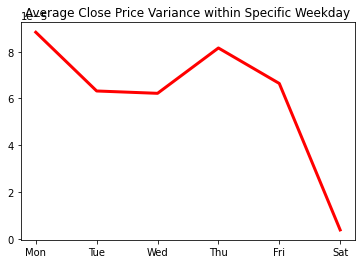

In [7]:
#看各交易日波動度，發現星期六波動度太低，星期六不玩較好。
MondayList = df[df["Weekday"] == 0]["Close"].tolist()
MondayVar = []
for i in range(int(len(MondayList)/288)):
    MondayVar.append(np.var(MondayList[i*288:(i+1)*288]))
TuesdayList = df[df["Weekday"] == 1]["Close"].tolist()
TuesdayVar = []
for i in range(int(len(TuesdayList)/288)):
    TuesdayVar.append(np.var(TuesdayList[i*288:(i+1)*288]))
WedList = df[df["Weekday"] == 2]["Close"].tolist()
WedVar = []
for i in range(int(len(WedList)/288)):
    WedVar.append(np.var(WedList[i*288:(i+1)*288]))
ThurList = df[df["Weekday"] == 3]["Close"].tolist()
ThurVar = []
for i in range(int(len(ThurList)/288)):
    ThurVar.append(np.var(ThurList[i*288:(i+1)*288]))
FriList = df[df["Weekday"] == 4]["Close"].tolist()
FriVar = []
for i in range(int(len(FriList)/288)):
    FriVar.append(np.var(FriList[i*288:(i+1)*288]))
SatList = df[df["Weekday"] == 5]["Close"].tolist()
SatVar = []
for i in range(int(len(SatList)/288)):
    SatVar.append(np.var(SatList[i*288:(i+1)*288]))
VaR = [np.mean(MondayVar),
np.mean(TuesdayVar),
np.mean(WedVar),
np.mean(ThurVar),
np.mean(FriVar),
np.mean(SatVar),]
plt.plot(["Mon","Tue","Wed","Thu","Fri","Sat"], VaR,linewidth=3, color="r")
plt.title("Average Close Price Variance within Specific Weekday")

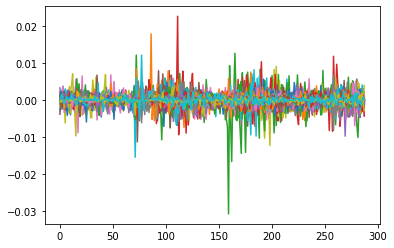

In [8]:
# 抓交易時間區段，選擇價格波動較明顯的區段來做當沖策略。
Close_diff_1 = []
for i in range(len(df["Close"])):
    if i == 0:
        Close_diff_1.append(df["Close"][i] - df["Open"][i])
    else:
        Close_diff_1.append(df["Close"][i] - df["Close"][i-1])
#簡單EDA
for i in range(int(len(Close_diff_1)/288)):
    if i < 50:
        plt.plot(Close_diff_1[i*288:(i+1)*288])

Text(0.5, 1.0, 'Average Close Price Variance within Specific Hour')

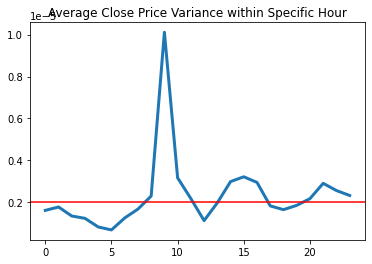

In [9]:
VaRR = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(877):
    intraDay_Close = df["Close"][i*288:(i+1)*288].tolist()
    for j in range(24):
        VaRR[j].append(np.var(intraDay_Close[12*j:12*(j+1)]))
meanVaRR = []
for i in range(len(VaRR)):
    meanVaRR.append(np.mean(VaRR[i]))
plt.plot(meanVaRR, linewidth = 3)
plt.axhline(y=0.000002, color='r', linestyle='-')
plt.title("Average Close Price Variance within Specific Hour")

In [10]:
meanVaRR[21]
#由此知，交易時段可挑5點開始，21~22點沖消掉！

2.9088905454200073e-06

In [11]:
# 加上時間濾網、外匯心理關卡策略，停損後會做reverse單
# 心理關卡當沖策略，交易天數為877天
# 每次交易單位為一手，方便計算。
# 手中維持持有一口部位而已。
counter_1 = 0
counter_2 = 0
counter_3 = 0
gain_loss_1 = []
gain_loss_2 = []
gain_loss_3 = []
accumulatedGainAndLoss = []
bankAccount = 50000 #USD，起始資金

for i in range(877):
    if df["Weekday"][i*288] != 5:
        buysignal = 0
        sellsignal = 0
        for j in range(288):
            if int(df["Datetime"][i*288+j].split(" ")[1].split(":")[0]) >= 5:
                if buysignal == 0:
                    if df["Close"][i * 288 + j] - df["floor"][i * 288 + j] < 0.01:
                        buysignal += 1
                        sellsignal -= 1
                        floor = df["floor"][i * 288 + j]
                        cost = df["Open"][i * 288 + j + 1]
                        number_b = i * 288 + j - 1
                elif sellsignal == 0:
                    if df["ceil"][i * 288 + j] - df["Close"][i * 288 + j] < 0.01:
                        buysignal -= 1
                        sellsignal += 1
                        ceil = df["ceil"][i * 288 + j]
                        cost = df["Open"][i * 288 + j + 1] 
                        number_s = i * 288 + j - 1
                elif buysignal == 1:
                    if (df["Close"][i * 288 + j] - cost) > 0.02:
                        buysignal -= 1
                        sellsignal += 1
                        bankAccount += ((df["Open"][i * 288 + j + 1] - cost) * 100000) / (df["Open"][i * 288 + j + 1])
                        counter_1 += 1
                        gain_loss_1.append(((df["Open"][i * 288 + j + 1] - cost) * 100000)/ (df["Open"][i * 288 + j + 1]))
                    elif (df["Close"][i * 288 + j] - cost) < -0.02:
                        #轉空單
                        buysignal -= 2
                        sellsignal += 2
                        bankAccount += ((df["Open"][i * 288 + j + 1] - cost) * 100000)/(df["Open"][i * 288 + j + 1])
                        counter_2 += 1
                        gain_loss_2.append(((df["Open"][i * 288 + j + 1] - cost) * 100000)/(df["Open"][i * 288 + j + 1]))
                        cost = df["Open"][i * 288 + j + 1]
                        number_s = i * 288 + j - 1
                    elif int(df["Datetime"][i * 288 + j].split(" ")[1].split(":")[0]) >= 21:
                        # 最晚22:00要跑，後續就不做交易了。
                        if (df["Close"][i * 288 + j] - cost) > 0.005:
                            buysignal = 100 
                            sellsignal = 100
                            bankAccount += ((df["Open"][i * 288 + j + 1] - cost) * 100000) / (df["Open"][i * 288 + j + 1])
                            counter_3 += 1
                            gain_loss_3.append(((df["Open"][i * 288 + j + 1] - cost) * 100000)/(df["Open"][i * 288 + j + 1]))
                        elif int(df["Datetime"][i * 288 + j].split(" ")[1].split(":")[0]) == 22:
                            buysignal = 100 
                            sellsignal = 100
                            bankAccount += ((df["Open"][i * 288 + j + 1] - cost) * 100000) / (df["Open"][i * 288 + j + 1])
                            counter_3 += 1
                            gain_loss_3.append(((df["Open"][i * 288 + j + 1] - cost) * 100000)/(df["Open"][i * 288 + j + 1]))
                elif sellsignal == 1:
                    if (cost - df["Close"][i * 288 + j]) > 0.02:
                        buysignal += 1
                        sellsignal -= 1
                        bankAccount += ((cost - df["Open"][i * 288 + j + 1]) * 100000) / (df["Open"][i * 288 + j + 1])
                        counter_1 += 1
                        gain_loss_1.append(((cost - df["Open"][i * 288 + j + 1]) * 100000)/(df["Open"][i * 288 + j + 1]))
                    elif (cost - df["Close"][i * 288 + j]) < -0.02:
                        #轉多單
                        buysignal += 2
                        sellsignal -= 2
                        bankAccount += ((cost - df["Open"][i * 288 + j + 1]) * 100000)/(df["Open"][i * 288 + j + 1])
                        counter_2 += 1
                        gain_loss_2.append(((cost - df["Open"][i * 288 + j + 1]) * 100000)/(df["Open"][i * 288 + j + 1]))
                        cost = df["Open"][i * 288 + j + 1]
                        number_b = i * 288 + j - 1
                    elif int(df["Datetime"][i * 288 + j].split(" ")[1].split(":")[0]) >= 21:
                        # 最晚22:00要跑，後續就不做交易了。
                        if (cost - df["Close"][i * 288 + j]) > 0.005:
                            buysignal = 100 
                            sellsignal = 100
                            bankAccount += ((cost - df["Open"][i * 288 + j + 1]) * 100000)/(df["Open"][i * 288 + j + 1])
                            counter_3 += 1
                            gain_loss_3.append(((cost - df["Open"][i * 288 + j + 1]) * 100000)/(df["Open"][i * 288 + j + 1]))
                        elif int(df["Datetime"][i * 288 + j].split(" ")[1].split(":")[0]) == 22:
                            buysignal = 100 
                            sellsignal = 100
                            bankAccount += ((cost - df["Open"][i * 288 + j + 1]) * 100000)/(df["Open"][i * 288 + j + 1])
                            counter_3 += 1
                            gain_loss_3.append(((cost - df["Open"][i * 288 + j + 1]) * 100000)/(df["Open"][i * 288 + j + 1]))
        accumulatedGainAndLoss.append(sum(gain_loss_1+gain_loss_2+gain_loss_3))
counter = counter_1 + counter_2 + counter_3

In [12]:
# 總交易次數
counter

576

In [13]:
# 最後帳戶餘額
bankAccount

62512.4071126615

In [14]:
win = 0
lose = 0
for i in (gain_loss_1 + gain_loss_2 + gain_loss_3):
    if i > 0:
        win+=1
    else:
        lose+=1
# 勝率
win/counter

0.5625

In [15]:
#Revenue
Revenue = bankAccount - 50000

#淨利，交易成本為6個bps
NetProfit = round(Revenue - counter * 0.0006 * 100000 / 7)

NetProfit

7575.0

In [16]:
#幾何平均日報酬率
Geo_DailyReturn = (1+NetProfit/50000)**(1/877)-1

#年化報酬率
Year_Return = (1+Geo_DailyReturn)**260-1
Year_Return

0.04270781434059323

Text(0.5, 1.0, 'Accumulated Return')

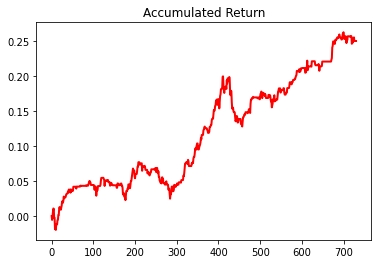

In [17]:
accumulatedGainAndLoss = [i/50000 for i in accumulatedGainAndLoss]
plt.plot(accumulatedGainAndLoss, color="r", linewidth=2)
plt.title("Accumulated Return")

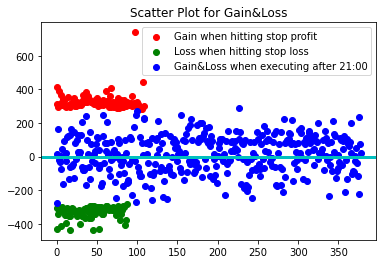

In [18]:
a = [i for i in range(len(gain_loss_1))]
b = [i for i in range(len(gain_loss_2))]
c = [i for i in range(len(gain_loss_3))]
#報酬變異情況
plt.scatter(a, gain_loss_1, color = "r", label = "Gain when hitting stop profit")
plt.scatter(b, gain_loss_2, color = "g", label = "Loss when hitting stop loss")
plt.scatter(c, gain_loss_3, color = "b", label = "Gain&Loss when executing after 21:00")
plt.axhline(y=0, color='c', linestyle='-', linewidth=3)
plt.title("Scatter Plot for Gain&Loss")
plt.legend()

In [19]:
#最大虧損
maximizedLoss = round(min(gain_loss_1+gain_loss_2+gain_loss_3))

#最大獲利
maximizedGain = round(max(gain_loss_1+gain_loss_2+gain_loss_3))

print(maximizedLoss,maximizedGain)

-436.0 739.0
